In [169]:
%load_ext autoreload
%autoreload 2

# General
import pynwb
import numpy as np

# pip install python-intervals (NOT 'intervals')
import intervals as iv

# Local
import query_helpers as qu
import nwb_query as query

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'lines.solid_capstyle': 'butt'})
mdates.rcParams.update({'date.autoformatter.microsecond': '%H:%M:%S.%f'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Todo
- behavior (position/speed) indexed by time, and not by epoch name
    -requires concatenating behav on import
- interpolate position at spike times (instead of using searchsorted)

### Data import and analysis parameters

In [170]:
# what data to analyze
d = {}
d['anim'] = 'Bon'
d['day'] = 4 # 1-indexed

d['epoch'] = 4 # 1-indexed
d['cluster_id'] = 30

# analysis configuration
c = {}
c['speed_threshold'] = 0.05 # m/s

### Read NWB file

In [171]:
animday = '{}{:02d}'.format(d['anim'], d['day'])
nwb_filename = './' + animday + '_test.nwb'

print('Loading file: %s' % nwb_filename)
io = pynwb.NWBHDF5IO(nwb_filename, mode='r')
nwbf = io.read()
 
sst = nwbf.session_start_time.timestamp()

Loading file: ./Bon04_test.nwb


### Dataset Query: speed of a given animal, day, and epoch
#### NWBFile (one animal), day, epoch --> ContinuousProcess (speed)

In [172]:
speed_module_name = 'Speed d{:d} e{:d}'.format(d['day'], d['epoch']) # HACKY--we should query on epoch directly
speed_h5py = nwbf.modules['Behavior']['Speed'][speed_module_name]
speed = query.ContinuousData(data=speed_h5py.data[()], timestamps=speed_h5py.timestamps[()])

### Dataset Query: spiking of a given animal and cluster
#### NWBFile (one animal), cluster --> PointProcess (spiking)

In [173]:
# Get spike times and obs_intervals
spikes_t = nwbf.units['spike_times'][d['cluster_id']]
obs_intervals = query.TimeIntervals(nwbf.units['obs_intervals'][d['cluster_id']])
spiking = query.PointProcess(event_times=spikes_t,
                             obs_intervals=obs_intervals)
#assert(spiking.events_in_intervals())
print('# of spikes = %d' % spiking.event_times.size)
print('# of intervals = %d' % len(spiking.obs_intervals))

# of spikes = 2192
# of intervals = 7


### Analysis: Find time intervals where speed > 5
#### ContinuousData (speed), lambda function --> TimeIntervals
This is an analysis, not a query, because we are not simply selecting a subset of a given datatype. i.e. We are not asking for a subset of the speed data, but rather for the intervals where it fulfills a lambda function. The lambda function could have been something different, like "find the times of all upward threshold crossings, and then pad this by 5 seconds on either side.". Regardless of how simple or complex the lambda function is, we consider this to be an analysis. Using the output of this to select a subset of the spiking data, however, is a query.

In [174]:
speed_threshold_fn = lambda x: x > c['speed_threshold']
speed_gt_intervals = qu.intervals_from_continuous(speed.data, speed.timestamps, speed_threshold_fn)
speed_time_intervals = query.TimeIntervals(speed_gt_intervals)
print('# of intervals where speed > 5 = %d' % len(speed_time_intervals))

# of intervals where speed > 5 = 120


### Query: spiking during time intervals where speed > 5
#### PointProcess (spiking), TimeIntervals --> PointProcess (spiking)

In [175]:
spiking_while_running = spiking.time_query(speed_time_intervals)  # Use the built-in time query method on PointProcess

print('# of spikes = %d' % len(spiking_while_running.event_times))
print('# of intervals = %d' % len(spiking_while_running.obs_intervals))
print()



# of spikes = 120
# of intervals = 120



### Analysis: Get animal location at spike times
#### nx2 ContinuousData (position), PointProcess (spiking) --> nx2 np.array (animal positions)
This is an analysis because the animal location at specific event-times is not itself a ContinuousProcess. i.e. It is not strictly a subsetting of the speed process, but rather is extracting specific data points without any support of observation intervals.

In [176]:
position_module_name = 'Position d{:d} e{:d}'.format(d['day'], d['epoch']) # HACKY--we should query on epoch directly
position_h5py = nwbf.modules['Behavior']['Position'][position_module_name]
position = query.ContinuousData(position.data[()], position.timestamps[()])
r_pos_at_spikes_idx = np.searchsorted(position.timestamps, spiking_while_running.event_times)  # indices of animal location at spike times
r_pos_at_spikes = position.data[r_pos_at_spikes_idx, :]                                        # animal location at spike times

### Analysis: Get animal locations during spike observation intervals for rate normalization 
#### nx2 ContinuousData (position), TimeIntervals --> nx2 np.array (position)
This is an analysis because we are extracting the speed data without any support.

In [177]:
r_pos_idx = qu.times_in_intervals(position.timestamps, speed_gt_intervals, return_indices=True)
r_pos = position.data[r_pos_idx, :]


### Plot spikes by location

Text(0.5,1,'Spike-position map for Bon d4 e4 c30, speed > 0.05 m/s')

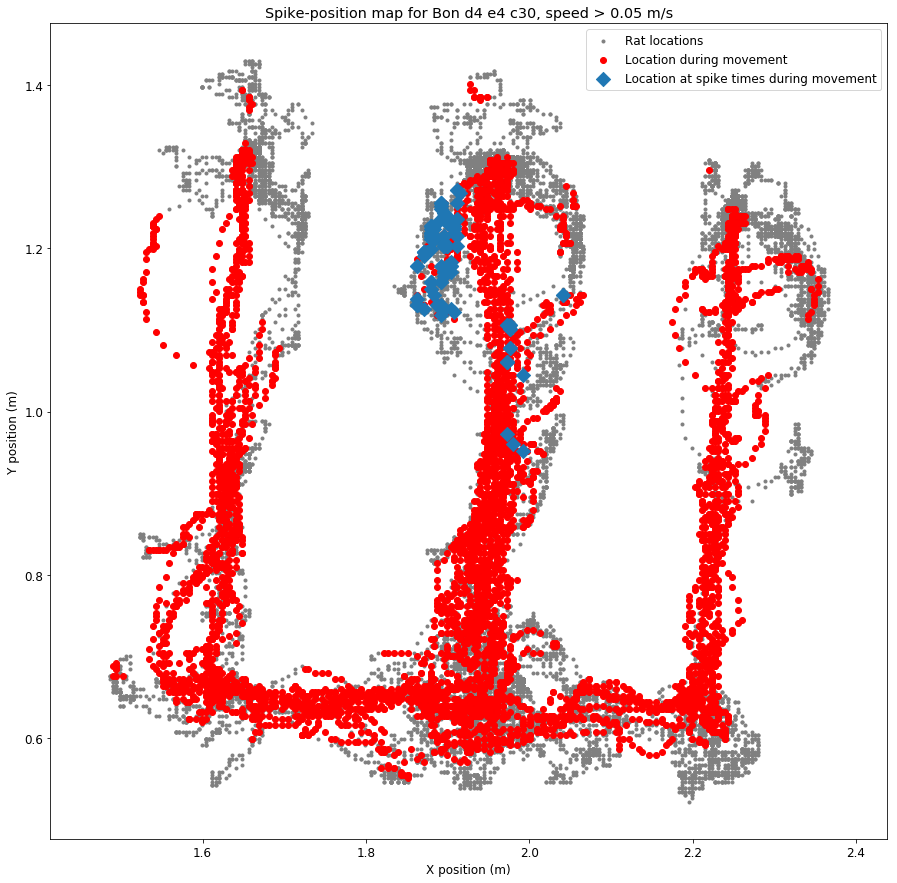

In [178]:
fig1 = plt.figure(1, figsize=(15,15))
ax1 = fig1.add_subplot(1,1,1)
ax1.axis('equal')

plt.scatter(position.data[:,0], position.data[:,1], marker='.', color='gray', label='Rat locations')
plt.scatter(r_pos[:,0], r_pos[:,1], marker='o', color='red', label='Location during movement')
plt.scatter(r_pos_at_spikes[:,0], r_pos_at_spikes[:,1], marker='D', s=100, label='Location at spike times during movement')

ax1.legend()
ax1.set_xlabel('X position (m)')
ax1.set_ylabel('Y position (m)')
ax1.set_title('Spike-position map for {} d{} e{} c{}, speed > {} m/s'.format(d['anim'], d['day'], d['epoch'], d['cluster_id'], c['speed_threshold']))

# position.data[0:10,0:2]
# position.timestamps[0:10]
# r_pos_ind_at_spikes
# r_pos_at_spikes